In [1]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from stylegan import G_synthesis

### Load synthesis network and the gaussian fit

In [2]:
generator = G_synthesis().cuda()
generator.load_state_dict(torch.load("models/synthesis.pt"))
gaussian_fit = torch.load("models/gaussian_fit.pt")

#### Freeze the generator parameters

In [3]:
for param in generator.parameters():
        param.requires_grad = False

In [4]:
img_lr = torchvision.transforms.ToTensor()(Image.open("imgs/face16.png")).unsqueeze(0).cuda()
assert img_lr.shape[1] == 3, "Should be RGB"

In [5]:
lrelu = torch.nn.LeakyReLU(negative_slope=0.2)

#### Noise
Fixed one, from gaussian

In [6]:
noise = [torch.randn((1, 1, 2**(i//2+2), 2**(i//2+2)), 
              dtype=torch.float, device='cuda', requires_grad=False) 
              for i in range(18)
             ]

### StyleGAN flow
 -  Mapping: $R^{512} \rightarrow R^{512}$
 -  Tiling Functtion: $R^{512} \rightarrow R^{18\times 512}$
 -  Synthesis: $R^{18\times 512} \times \text{noise} \rightarrow R^{1024\times 1024} $

Surprisingly, to draw **uniformly** from the sphere, first we gotta draw points from normal, and then normalize the point ([Method 19](http://extremelearning.com.au/how-to-generate-uniformly-random-points-on-n-spheres-and-n-balls/))

In [7]:
#  Sample the latent vector from normal distr.
latent = torch.randn((1, 1, 512), dtype=torch.float, device='cuda', requires_grad=False)

#  Project to a unit sphere
# latent = latent.div(latent.norm(dim=2, keepdim=True))

# assert torch.isclose(latent.norm(dim=2, keepdim=True).squeeze(), torch.tensor(1.0))
radius = 0
with torch.no_grad():
    radius = latent.norm(dim=2, keepdim=True)
    
print("latent vector length: {}".format(radius))

#  Enable grad
latent.requires_grad = True

latent vector length: tensor([[[22.1424]]], device='cuda:0')


### Optimizer

In [8]:
optim = torch.optim.Adam([latent], lr=0.4)

In [9]:
mse = nn.MSELoss()#reduction='sum')
mse = mse.cuda()

generated_imgs = []
steps = 100

for step in range(steps):
   
    optim.zero_grad()

    
    z = latent
    z = z.expand(-1, 18, -1)
    z = lrelu(z * gaussian_fit["std"] + gaussian_fit["mean"])

    img_sr = generator(z, noise)
    img_sr = (img_sr + 1.0) / 2.0
    
    
    #  Downsample bicubically
    img_sr_ds = nn.functional.interpolate(img_sr, img_lr[0].size()[1:], mode='bicubic')
        
    loss = mse(img_lr, img_sr_ds)

    if step % (steps / 10) == 0:
        generated_imgs.append(img_sr.detach().clone())
        

    loss.backward()
    optim.step()
    

    with torch.no_grad():
        latent.div_(latent.norm(dim=2, keepdim=True) + 1e-10)
        latent.mul_(radius)

/home/przm/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [10]:
eps = 2*1e-3
print("Loss: {:.5} is {} < {}".format(loss, "" if loss.item() < eps else "NOT", eps ))

Loss: 0.0017146 is  < 0.002


## Display results

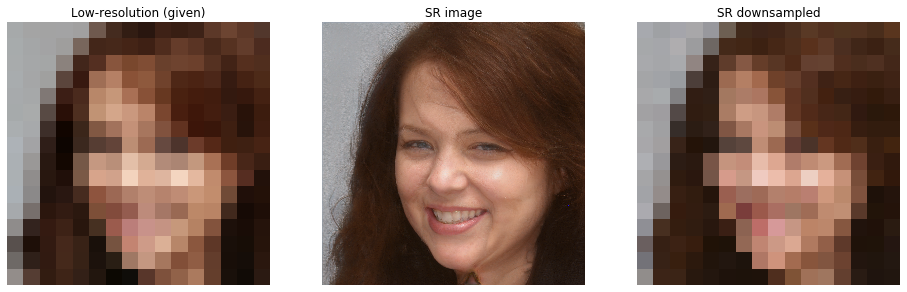

In [11]:
def to_numpy(img):
    return np.array(torchvision.transforms.ToPILImage()(img.cpu()))

before = to_numpy(img_lr[0])
after = to_numpy(img_sr[0])
after_lr = to_numpy(img_sr_ds[0])

titles = ['Low-resolution (given)', 'SR image', 'SR downsampled']
imgs = [before, after, after_lr]

fig, axs = plt.subplots(1, 3, figsize=(16, 12))

for a, img, title in zip(axs, imgs, titles):
    a.imshow(img)
    a.axis('off')
    a.set_title(title)

#### Show intermediate pics

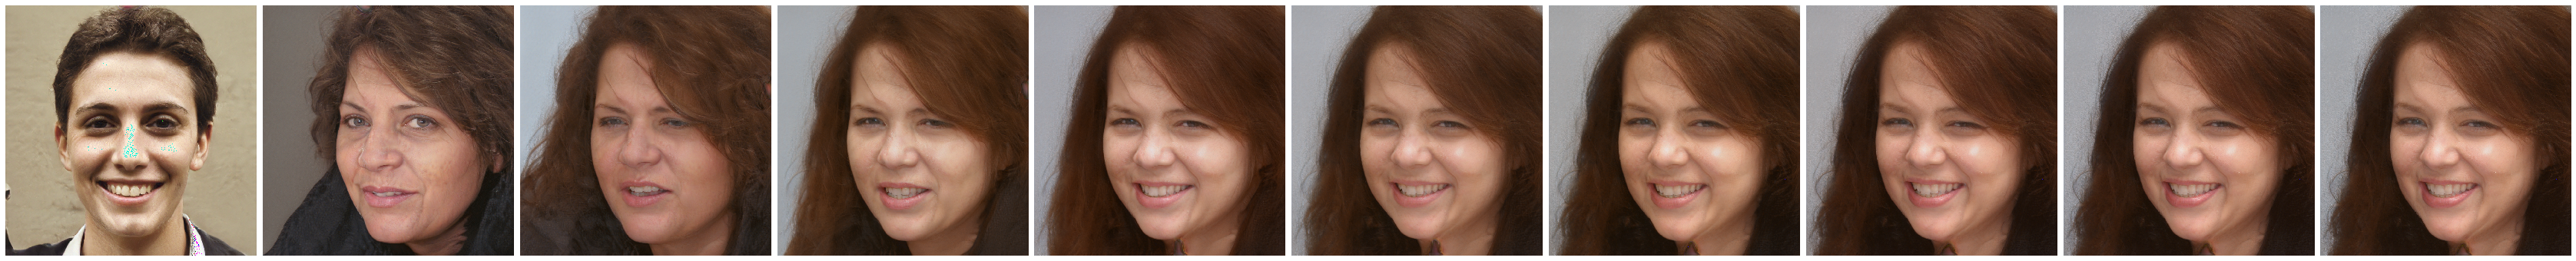

In [12]:
nimg = len(generated_imgs)
fig, axs = plt.subplots(1, nimg, figsize=(6*nimg, 6))

for a, img in zip(axs, generated_imgs):
    a.imshow(to_numpy(img[0]))
    a.axis('off')
plt.subplots_adjust(wspace=0.0, hspace=0.0)

#### Genereate a gif

In [13]:
gif = [torchvision.transforms.ToPILImage()(img[0].cpu()).resize((256, 256)) for img in generated_imgs]

gif[0].save('out.gif', save_all=True, append_images=gif[1:], loop=0, duration=100)